# Parcial 2
### **Elaboró: Anette Paulina González Solano**

In [1]:
import scipy.io # Leer .mat
import pandas as pd # DataFrames y percentiles
import networkx as nx # Análisis de redes, métricas
import numpy as np # Operaciones numéricas y matrices
import seaborn as sns # Mapas de calor, histogramas
import matplotlib.pyplot as plt # Gráficas 2D y 3D

In [2]:
# Cargar archivo .mat
mat = scipy.io.loadmat('Coactivation_matrix.mat')
# Extraer matrices relevantes
coact_matrix = mat['Coactivation_matrix'] # Matriz de coactivación (638 x 638), en este caso actúa como matriz de conectividad funcional (indica activación sincrónica entre dos puntos)
coords = mat['Coord'] # Coordenadas 3D de los nodos (638 x 3)
# Crear grafo de 'coact_matrix' (es ponderado y no dirigido)
G = nx.from_numpy_array(coact_matrix)

In [3]:
# (Solo para visualizar datos) DataFrame de 'coact_matrix'
df_coact_matrix = pd.DataFrame(coact_matrix)
# (Solo para visualizar datos) DataFrame de 'coords'
df_coords = pd.DataFrame(coords)

df_coact_matrix, df_coords

(          0         1         2         3         4        5         6    \
 0    0.000000  0.160714  0.111486  0.000000  0.138095  0.00000  0.000000   
 1    0.160714  0.000000  0.068259  0.000000  0.042056  0.00000  0.000000   
 2    0.111486  0.068259  0.000000  0.224199  0.000000  0.00000  0.000000   
 3    0.000000  0.000000  0.224199  0.000000  0.000000  0.00000  0.039275   
 4    0.138095  0.042056  0.000000  0.000000  0.000000  0.00000  0.000000   
 ..        ...       ...       ...       ...       ...      ...       ...   
 633  0.053872  0.042105  0.161905  0.000000  0.000000  0.00000  0.000000   
 634  0.049383  0.000000  0.103943  0.075697  0.000000  0.03876  0.000000   
 635  0.000000  0.000000  0.034130  0.108787  0.000000  0.00000  0.105839   
 636  0.050459  0.000000  0.000000  0.000000  0.103448  0.00000  0.000000   
 637  0.101124  0.069231  0.000000  0.000000  0.053279  0.00000  0.000000   
 
           7    8         9    ...  628       629  630  631       632  \
 

## **1. Utilizando el dataset de _Coactivation_matrix.mat_:**
   
    1.1 Calcule el coeficiente de mundo pequeño

    1.2 Calcule las comunidades del grafo

    1.3 Calcule los hub

    1.4 Calcule la eficiencia global

    1.5 Calcule la eficiencia local

    1.6 Determine el grado de cada nodo

In [4]:
# 1.1 Coeficiente de mundo pequeño
# Mundo pequeño: ↑ coeficiente de clustering + ↓ longitud promedio

# Coeficiente de clustering: ¿Qué tan conectados están los vecinos de un nodo entre sí?
clustering = nx.average_clustering(G, weight='weight') # Si no ponemos weight = 'weight' , se calcula clustering binario (0 y 1)
# Longitud promedio de los caminos más cortos entre nodos: ¿Cuántos pasos en promedio se necesitan para ir de un nodo a otro? (valor bajo = red eficiente)
path_length = nx.average_shortest_path_length(G, weight='weight')
# Coeficiente de mundo pequeño
small_world_coef = clustering / path_length

print("Coeficiente de clustering:", clustering)
print("Longitud promedio de caminos más cortos:", path_length)
print("Longitud promedio de mundo pequeño:", small_world_coef)

Coeficiente de clustering: 0.06628349536448998
Longitud promedio de caminos más cortos: 0.08177307632144148
Longitud promedio de mundo pequeño: 0.8105784733343825


In [5]:
# 1.2 Comunidades del grafo
# Comunidad: grupo de nodos más conectados entre sí que con el resto de nodos (i.e., posibles regiones funcionales)

# Importar módulo de detección de comunidades (networkx)
from networkx.algorithms import community

# Detectar comunidades en G usando Louvain
comunidades = community.louvain_communities(G, weight = 'weight')
print("Número de comunidades:", len(comunidades))
for i, comunidad in enumerate(comunidades):
    print(f"Comunidad {i+1}: {len(comunidad)} nodos")
# Calcular modularidad: ¿Qué tan bien conectados están los nodos dentro de su comunidad? (~1 = muy fuerte)
modularidad = community.modularity(G, comunidades, weight = 'weight')
print("Modularidad:", modularidad)

Número de comunidades: 5
Comunidad 1: 140 nodos
Comunidad 2: 186 nodos
Comunidad 3: 118 nodos
Comunidad 4: 147 nodos
Comunidad 5: 47 nodos
Modularidad: 0.4734959971790668


In [6]:
# 1.3 Hub: nodo con ↑ grado + ↑ centralidad de intermediación + ↑ centralidad de cercanía

# Grado: ¿Cuántas aristas tiene cada nodo?
grados = dict(G.degree(weight='weight')) # Ponderado por fuerza
# Invertir: distancia = 1 / fuerza sináptica
inv_weights = {(u, v): 1/d['weight'] for u, v, d in G.edges(data=True) if d['weight'] > 0}
nx.set_edge_attributes(G, inv_weights, 'inv_weight')
# Centralidad de intermediación: ¿Cuántos caminos más cortos incluyen a un nodo?
intermediación = nx.betweenness_centrality(G, weight='inv_weight', normalized=True)
# Centralidad de cercanía: ¿Qué tan cerca está un nodo de todos los demás nodos en el grafo?
cercanía = nx.closeness_centrality(G, distance='inv_weight')

# Combinar medidas normalizadas en un “hub score"
hub_score = {n: (
                  grados[n]/max(grados.values()) +   # Normalizado a 0–1
                  intermediación[n]/max(intermediación.values()) +
                  cercanía[n]/max(cercanía.values())
              ) / 3
             for n in G.nodes()}

# Top 10 hubs
top_10_hubs = sorted(hub_score.items(), key = lambda x: x[1], reverse = True)[:10] # hub_score.items() obtiene pares (nodo, puntaje)

print("Top 10 hubs según su hub score:")
for n, score in top_10_hubs:
    print(n, round(score, 4))

Top 10 hubs según su hub score:
235 0.9746
330 0.8659
482 0.8268
230 0.7751
121 0.7693
38 0.7643
202 0.763
485 0.7521
416 0.745
488 0.7365


In [7]:
# 1.4 Eficiencia global: ¿Qué tan eficiente es la red para transmitir información?
ef_global = nx.global_efficiency(G)
print("Eficiencia global:", ef_global) # (~1 = mejor eficiencia)

Eficiencia global: 0.49492420551600974


In [8]:
# 1.5 Eficiencia local: ¿Qué tan eficiente es la comunicación entre los vecinos de cada nodo?
# Cerebro sano: ↑ eficiencia global y local
ef_local = nx.local_efficiency(G)
print("Eficiencia local:", ef_local) # (~1 = mejor eficiencia)

Eficiencia local: 0.6643934695960994


In [9]:
# 1.6 Grado (ponderado) de cada nodo

# Ordenar grados descendentemente 
grado_ordenado = sorted(grados.items(), key = lambda x: x[1], reverse = True)
print("Nodo      Grado")                
for n, g in grado_ordenado:
    print(f"{n:<10} {g:<5}")

Nodo      Grado
330        10.859577501411028
482        10.71673896805265
235        10.030670244033184
485        10.026901174441468
230        10.01498183944764
38         9.637577305333636
356        9.58082247835378
400        9.573203825449035
416        9.537796862045944
328        9.230982898334778
491        9.16808480670646
494        8.941821315539054
350        8.869131623586737
496        8.81732687371816
488        8.806477200779097
481        8.763359759557396
346        8.729322759553742
622        8.512698131470637
629        8.383947634828145
121        8.252228377762107
397        8.159166979423603
237        7.963303292228362
421        7.809024302835386
418        7.77820856946653
100        7.609337721731402
202        7.568966298786686
353        7.554851432608897
621        7.5422011993071845
465        7.3992177079493615
135        7.345756934423368
327        7.3198625387749034
630        7.293116381017982
286        7.268166220401057
334        7.235730818583

## **2. Utilizando el dataset de _Coactivation_matrix.mat_:**
   
    2.1 Generar el mapa de calor de cada matriz de conectividad
   
    2.2 Generar la distribución de datos de cada matriz de conectividad
   
    2.3 ¿Qué valor se encuentra en el percentil 0.25, 0.5 y 0.75 de la matriz de conectividad?
   
    2.4 Cree los 3 grafos 2D filtrando la matriz de conectividad con los valores dados por los percentiles del ejercicio anterior

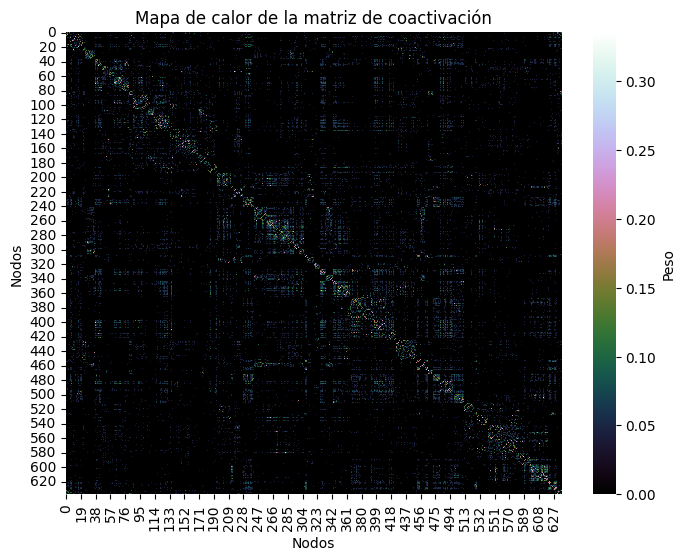

In [10]:
# 2.1 Mapa de calor de 'coact_matrix'

plt.figure(figsize=(8, 6))
sns.heatmap(coact_matrix, cmap='cubehelix', cbar_kws={'label': 'Peso'})
plt.title("Mapa de calor de la matriz de coactivación"), plt.xlabel("Nodos"), plt.ylabel("Nodos")
plt.show()

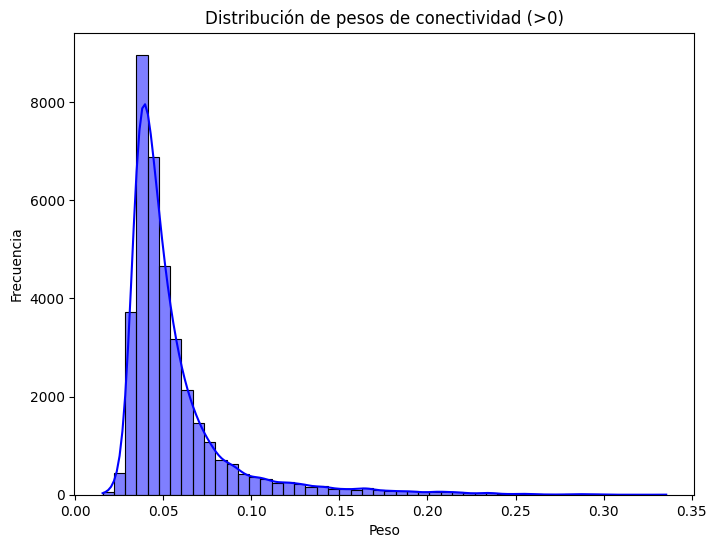

In [11]:
# 2.2 Valores de conectividad de 'coact_matrix'

# Filtrar valores mayores a cero (ver solo conexiones activas)
pesos_válidos = coact_matrix[coact_matrix > 0].flatten()
# Graficar distribución de conexiones activas
plt.figure(figsize=(8, 6))
sns.histplot(pesos_válidos, bins = 50, kde = True, color = 'blue')
plt.title("Distribución de pesos de conectividad (>0)"), plt.xlabel("Peso"), plt.ylabel("Frecuencia")
plt.show()

In [12]:
# 2.3 Percentiles de 'coact_matrix'

# Calcular percentiles sobre conexiones activas
p25, p50, p75 = np.percentile(pesos_válidos, [25, 50, 75])
print("P25:", p25, "  P50:", p50, "  P75:", p75) # Muchas conexiones activas débiles, pocas fuertes (75% no supera 0.06)

P25: 0.03832752613240418   P50: 0.046052631578947366   P75: 0.06053268765133172


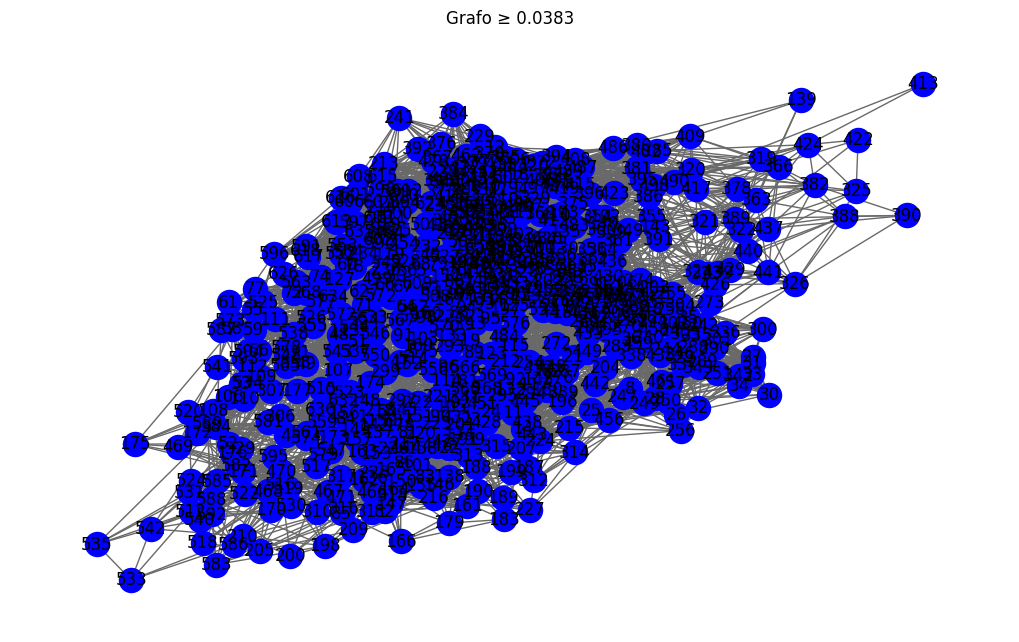

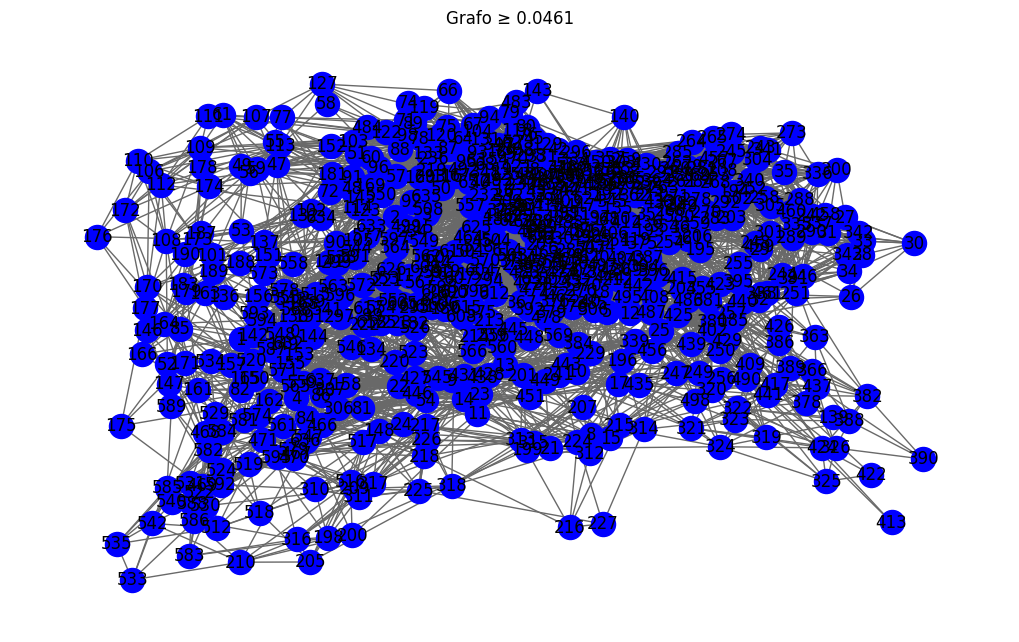

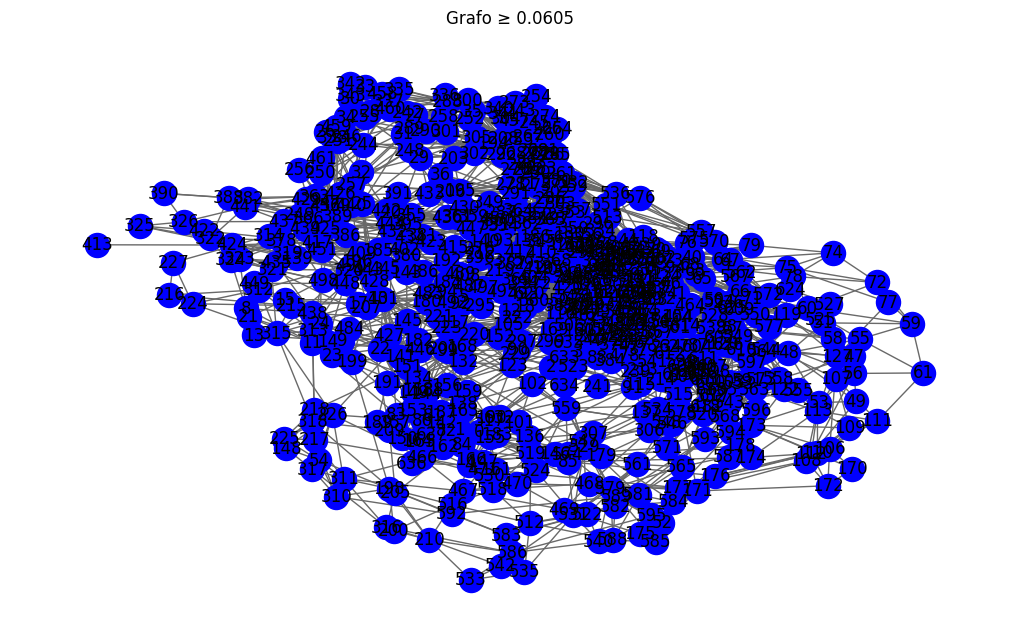

In [23]:
# 2.4 Grafos filtrados por percentiles

for p in [p25, p50, p75]:
    coact_matrix_filtrada = np.where(coact_matrix >= p, coact_matrix, 0)
    G_filtrado = nx.from_numpy_array(coact_matrix_filtrada)
    plt.figure(figsize = (10,6))
    nx.draw(G_filtrado, with_labels = True, node_color = 'blue', edge_color = 'dimgray')
    plt.title(f"Grafo ≥ {p:.4f}")
    plt.show()

## **3. Utilizando el dataset de _Coactivation_matrix.mat_:**

    3.1 Genere el grafo 3D
  
    3.2 Haga que el tamaño de nodos sea proporcional a su grado; es decir, que entre mayor sea su grado, mayor sea el tamaño del nodo ploteado

    3.3 Haga que el color de las aristas este relacionado al valor de la matriz de conectividad. Utilizar el map color Hot

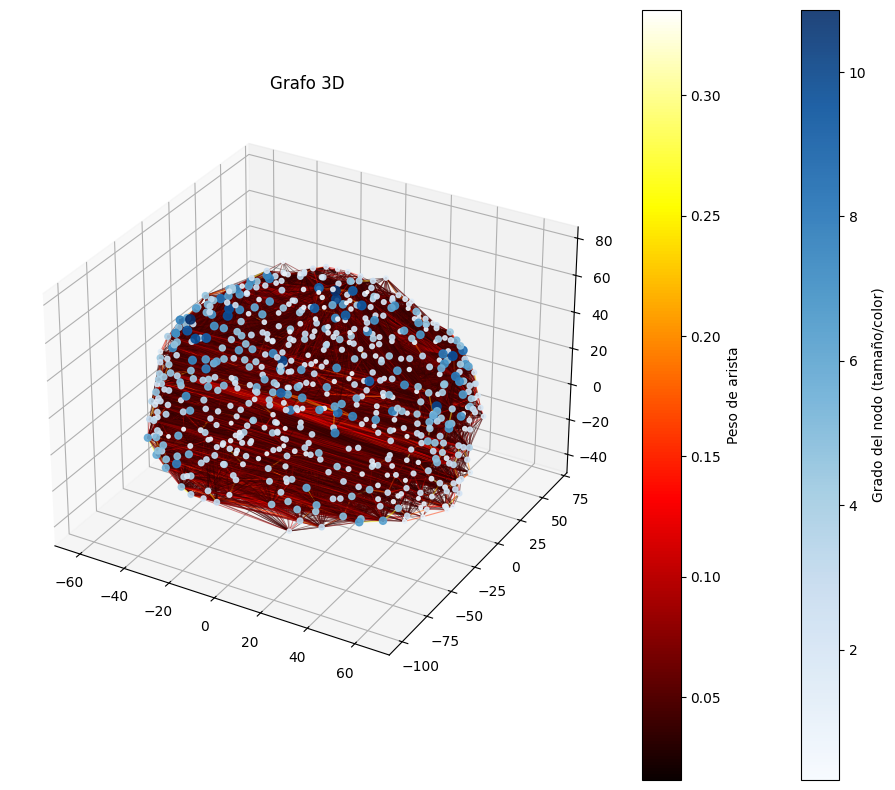

In [14]:
from matplotlib import cm

# 3.1 Grafo 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 3.2 Tamaño y color de nodos según grado
deg = np.array([d for _, d in G.degree(weight='weight')])
# Tamaño proporcional al grado
size = 40 * (deg / deg.max() + 0.1)   
# Dibujar nodos
sc = ax.scatter(coords[:,0], coords[:,1], coords[:,2],
                s=size, c=deg, cmap='Blues', alpha=0.9)
plt.colorbar(sc, ax=ax, label='Grado del nodo (tamaño/color)')

# 3.3 Color de aristas según peso
weights = np.array([d['weight'] for _,_,d in G.edges(data=True)])
norm_w = plt.Normalize(weights.min(), weights.max())  # Normalización para colormap

for (u,v,d) in G.edges(data=True):
    ax.plot([coords[u,0], coords[v,0]],
            [coords[u,1], coords[v,1]],
            [coords[u,2], coords[v,2]],
            color=cm.hot(norm_w(d['weight'])),
            alpha=0.5, lw=0.5 + 2*d['weight'])  # ancho proporcional al peso

plt.title("Grafo 3D")
plt.colorbar(cm.ScalarMappable(norm=norm_w, cmap='hot'), ax=ax, label='Peso de arista')
plt.show()

In [15]:
import mne

# Cargar archivo .edf
raw = mne.io.read_raw_edf('chb01_01.edf', preload=True)
# Extraer ddatos de EEG: shape = (n_channels, n_samples)
eeg_data = raw.get_data()
# Normalizamos cada canal (para mejorar correlaciones)
eeg_data = (eeg_data - eeg_data.mean(axis=1, keepdims=True)) / eeg_data.std(axis=1, keepdims=True)
# Etiquetar nodos con nombres de canales
channel_names = raw.ch_names

# Matriz de correlación entre canales
corr_matrix = np.corrcoef(eeg_data)
corr_matrix_pos = (corr_matrix + 1) / 2  # Todo en [0,1]
dist_matrix = 1 - corr_matrix_pos # Distancia para caminos cortos

# Crear grafo para clustering/hubs/comuniddes
G_corr = nx.from_numpy_array(corr_matrix_pos)
G_corr = nx.relabel_nodes(G_corr, dict(zip(range(len(channel_names)), channel_names)))
# Crear grafo para caminos cortos/eficiencia
G_dist = nx.from_numpy_array(dist_matrix)
G_dist = nx.relabel_nodes(G_dist, dict(zip(range(len(channel_names)), channel_names)))

Extracting EDF parameters from C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S04_parciales\parcial-2\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\apgso\AppData\Local\Temp\ipykernel_23312\924140500.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf('chb01_01.edf', preload=True)


**4. Utilizando el dataset de _chb01_01.edf_:**
    
    4.1 Calcule el coeficiente de mundo pequeño

    4.2 Calcule las comunidades del grafo

    4.3 Calcule los hub

    4.4 Calcule la eficiencia global

    4.5 Calcule la eficiencia local

    4.6 Determine el grado de cada nodo

In [16]:
# 4.1 Coeficiente de mundo pequeño

# Coeficiente de clustering
clustering = nx.average_clustering(G_corr, weight='weight')
# Longitud promedio de los caminos más cortos
path_length = nx.average_shortest_path_length(G_dist, weight='weight')
# Coeficiente de mundo pequeño
small_world_coef = clustering / path_length

print("Coeficiente de clustering:", clustering)
print("Longitud promedio de caminos más cortos:", path_length)
print("Longitud promedio de mundo pequeño:", small_world_coef)

Coeficiente de clustering: 0.5629961340015018
Longitud promedio de caminos más cortos: 0.4266977883044612
Longitud promedio de mundo pequeño: 1.3194259483711872


In [17]:
# 4.2 Comunidades del grafo

# Importar módulo de detección de comunidades 
from networkx.algorithms.community import greedy_modularity_communities
# Detectar comunidades en G_corr usando Louvain
comunidades = list(greedy_modularity_communities(G_corr, weight='weight'))
print("Número de comunidades:", len(comunidades))
for i, c in enumerate(comunidades):
    print(f"Comunidad {i+1}: {list(c)}")

Número de comunidades: 8
Comunidad 1: ['FP1-F3', 'FP1-F7', 'FP2-F4', 'FP2-F8']
Comunidad 2: ['P8-O2', 'P4-O2', 'P3-O1', 'P7-O1']
Comunidad 3: ['F7-T7', 'FT9-FT10', 'T7-P7']
Comunidad 4: ['F4-C4', 'FZ-CZ', 'F3-C3']
Comunidad 5: ['CZ-PZ', 'C3-P3', 'C4-P4']
Comunidad 6: ['P7-T7', 'F8-T8', 'FT10-T8']
Comunidad 7: ['T8-P8-1', 'T8-P8-0']
Comunidad 8: ['T7-FT9']


In [18]:
# 4.3 Hubs (utilizando un método diferente al archivo .mat)

hub_scores = nx.eigenvector_centrality(G_corr, max_iter=1000, weight='weight')
hub_ordenados = sorted(hub_scores.items(), key=lambda x: x[1], reverse=True)
print("Nodo      Hub score")
for n, h in hub_ordenados[:5]:  # Mostrar top 5
    print(f"{n:<10} {h:.3f}")

Nodo      Hub score
FZ-CZ      0.227
F4-C4      0.227
FP1-F7     0.224
F3-C3      0.224
FP2-F4     0.224


In [19]:
# 4.4 Eficiencia global
ef_global = nx.global_efficiency(G_dist)
print("Eficiencia global:", ef_global) # (~1 = mejor eficiencia)

Eficiencia global: 1.0


In [20]:
# 4.5 Eficiencia local
ef_local = nx.local_efficiency(G_dist)
print("Eficiencia local:", ef_local) # (~1 = mejor eficiencia)

Eficiencia local: 1.0


In [21]:
# Grado de cada nodo

grados = dict(G_corr.degree(weight='weight'))
# Ordenar grados descendentemente
grado_ordenado = sorted(grados.items(), key=lambda x: x[1], reverse=True)
print("Nodo      Grado")
for n, g in grado_ordenado:
    print(f"{n:<10} {g:.3f}")

Nodo      Grado
FZ-CZ      15.748
F4-C4      15.739
FP1-F7     15.553
CZ-PZ      15.524
FP2-F4     15.520
F3-C3      15.503
C4-P4      15.427
C3-P3      15.369
FP1-F3     15.355
FP2-F8     15.236
F8-T8      15.145
P4-O2      14.885
P7-O1      14.669
P3-O1      14.634
T8-P8-0    14.517
T8-P8-1    14.517
F7-T7      14.406
T7-P7      14.155
P8-O2      14.132
FT10-T8    12.783
T7-FT9     12.732
FT9-FT10   12.054
P7-T7      10.845


**5. Utilizando el dataset de _chb01_01.edf_:**

    5.1 Genere el grafo 3D

    5.2 Haga que el tamaño de nodos sea proporcional a su grado; es decir, q entre mayor sea su grado, mayor sea el tamaño del nodo ploteado

    5.3 Haga que el color de las aristas este relacionado al valor de la matriz de conectividad. Utilizar el map color Hot

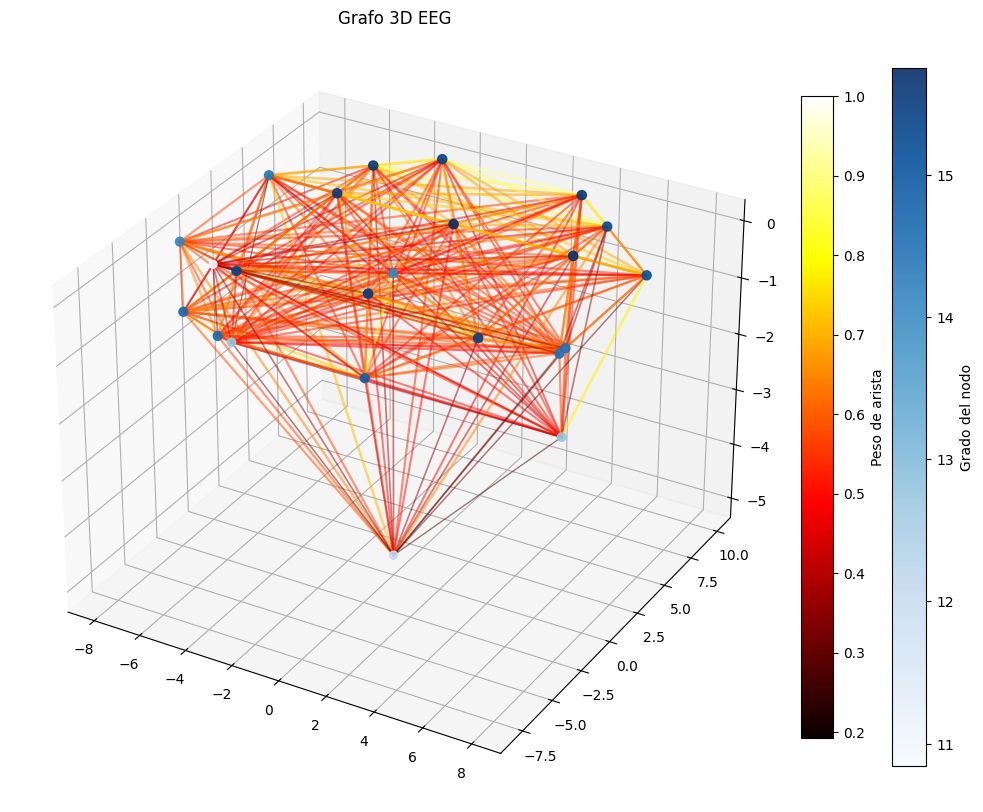

In [22]:
# Coordenadas 3D aproximadas 10-20 para los 23 canales del archivo EEG
coords_dict = {
    'FP1-F7': [-5, 8, 0], 'F7-T7': [-8, 5, 0], 'T7-P7': [-8, -2, 0], 'P7-O1': [-5, -7, 0],
    'FP1-F3': [-3, 10, 0], 'F3-C3': [-5, 5, 0], 'C3-P3': [-5, -3, 0], 'P3-O1': [-3, -8, 0],
    'FP2-F4': [3, 10, 0], 'F4-C4': [5, 5, 0], 'C4-P4': [5, -3, 0], 'P4-O2': [3, -8, 0],
    'FP2-F8': [5, 8, 0], 'F8-T8': [8, 5, 0], 'T8-P8-0': [8, -2, 0], 'T8-P8-1': [8, -2.5, 0],
    'FZ-CZ': [0, 5, 0], 'CZ-PZ': [0, -2, 0], 'FT9-FT10': [0, 0, -5], 'FT10-T8': [7, 0, -2],
    'T7-FT9': [-7, 0, -2], 'P7-T7': [-6, -3, 0]
}
# Crear una lista de coordenadas que siga el orden de G_corr.nodes()
coords = np.array([coords_dict.get(n, [0,0,0]) for n in G_corr.nodes()])

# 5.1 Grafo 3D
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# 5.2 Tamaño y color de nodos según grado
deg = np.array([d for _, d in G_corr.degree(weight='weight')])
node_sizes = 40 * (deg / deg.max() + 0.1)
sc_nodes = ax.scatter(coords[:,0], coords[:,1], coords[:,2],
                      s=node_sizes, c=deg, cmap='Blues', alpha=0.9)
plt.colorbar(sc_nodes, ax=ax, fraction=0.03, pad=0.05, label='Grado del nodo')

# 5.3 Color de aristas según peso
weights = np.array([d['weight'] for _, _, d in G_corr.edges(data=True)])
norm_edges = plt.Normalize(weights.min(), weights.max())

# Mapear nombres de nodos a índices
node_index = {n: i for i, n in enumerate(G_corr.nodes())}

for u, v, d in G_corr.edges(data=True):
    ui, vi = node_index[u], node_index[v]  # convertir nombres a índices
    ax.plot([coords[ui,0], coords[vi,0]],
            [coords[ui,1], coords[vi,1]],
            [coords[ui,2], coords[vi,2]],
            color=cm.hot(norm_edges(d['weight'])),
            alpha=0.5, lw=0.5 + 2*d['weight'])

cbar_edges = plt.colorbar(cm.ScalarMappable(norm=norm_edges, cmap='hot'),
                          ax=ax, fraction=0.03, pad=0.02)
cbar_edges.set_label("Peso de arista")

plt.title("Grafo 3D EEG")
plt.show()